In [111]:
import pickle
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from kafka import KafkaConsumer
from sklearn.metrics import f1_score
import copy
from collections import deque
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import (f1_score, precision_score, recall_score, 
                             confusion_matrix, roc_curve, auc,
                             precision_recall_curve, average_precision_score)

In [112]:
class GraphNet(nn.Module):
    def __init__(self, in_channels, gcn_hidden, dnn_hidden, out_channels):
        super().__init__()
        # -- GNN layers --
        self.gcn1 = GCNConv(in_channels, gcn_hidden)
        self.gcn2 = GCNConv(gcn_hidden, gcn_hidden)

        # -- DNN layers --
        self.lin1 = nn.Linear(gcn_hidden, dnn_hidden)
        self.lin2 = nn.Linear(dnn_hidden, out_channels)

    def forward(self, x, edge_index):
        # ----- GNN stage -----
        x = self.gcn1(x, edge_index)   # shape: [num_nodes, gcn_hidden]
        x = F.relu(x)
        x = self.gcn2(x, edge_index)   # shape: [num_nodes, gcn_hidden]
        x = F.relu(x)

        # ----- DNN stage -----
        x = self.lin1(x)              # shape: [num_nodes, dnn_hidden]
        x = F.relu(x)
        x = self.lin2(x)              # shape: [num_nodes, out_channels]

        return F.log_softmax(x, dim=1) # for multi-class or binary classification

In [113]:
with open('scaler.pkl', 'rb') as scaler_file:
    scaler = joblib.load(scaler_file)
feature_columns = scaler.feature_names_in_
print("Scaler loaded successfully!")

Scaler loaded successfully!


In [114]:
#Load data stream
consumer = KafkaConsumer(
    'ml-raw-dns',
    bootstrap_servers="localhost:9092",
    auto_offset_reset='earliest',
    enable_auto_commit=False,
    consumer_timeout_ms=5000
)

if consumer.bootstrap_connected():
    print("Successfully connected to Kafka broker")
else:
    print("Couldn't connect to bootstrap server.")

Successfully connected to Kafka broker


In [115]:
model = GraphNet(
    in_channels=len(feature_columns),  # number of features
    gcn_hidden=128,           # size of GCN hidden embeddings
    dnn_hidden=64,           # size of hidden layer in the MLP
    out_channels=2           # final classes (0=Benign, 1=Attack)
)
model.load_state_dict(torch.load("GNN_DNN_weights.pth", map_location=torch.device('cpu')))
model.eval()

GraphNet(
  (gcn1): GCNConv(78, 128)
  (gcn2): GCNConv(128, 128)
  (lin1): Linear(in_features=128, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=2, bias=True)
)

In [116]:
static_model = model
dynamic_model = copy.deepcopy(model)

In [117]:
feature_columns = scaler.feature_names_in_  # list of feature column names
window_size = 500
max_window_steps = 5
window_count = 0
window_data = deque(maxlen=window_size)

dynamic_model_f1 = []
static_model_f1 = []
window_indices = []

print("Starting to consume messages...")

for idx, message in enumerate(consumer):
    # Decode and split the incoming message
    row = message.value.decode().strip().split(',')
    
    try:
        row_df = pd.DataFrame([row], columns=[*feature_columns, 'label'])
    except ValueError:
        print(f"Skipping invalid row: {row}")
        continue
    
    if 'Unnamed: 0' in row_df.columns:
        row_df.drop('Unnamed: 0', axis=1, inplace=True)
    
    if 'label' in row_df.columns:
        row_df['label'] = row_df['label'].apply(lambda x: x.strip().replace('\\n"', '').replace('"', ''))
        # Ensure the 'label' column contains valid integers
        row_df = row_df[pd.to_numeric(row_df['label'], errors='coerce').notnull()]
        if row_df.empty:
            print(f"Skipping row with invalid label: {row}")
            continue
        row_df['label'] = row_df['label'].astype(int)
    
    for col in feature_columns:
        row_df[col] = pd.to_numeric(row_df[col], errors='coerce').fillna(0)
    
    row_df[feature_columns] = scaler.transform(row_df[feature_columns])

    X_new = row_df[feature_columns].values  # shape: [1, n_features]
    y_new = int(row_df['label'].values[0])
    
    window_data.append((X_new[0], y_new))
    
    if idx % 100 == 0:
        print(f"Consumed {idx} messages")
    
    if len(window_data) == window_size:
        # Extract ground truth and predictions from the window
        X_window = np.array([entry[0] for entry in window_data])
        y_window = np.array([entry[1] for entry in window_data])
        
        k = 5
        knn_graph = kneighbors_graph(X_window, n_neighbors=k, include_self=False)
        row_idx, col_idx = knn_graph.nonzero()
        edge_index = torch.tensor([row_idx, col_idx], dtype=torch.long)
        
        X_window_tensor = torch.tensor(X_window, dtype=torch.float32)
        y_window_tensor = torch.tensor(y_window, dtype=torch.long)

        with torch.no_grad():
            dynamic_logits = dynamic_model(X_window_tensor, edge_index)
            static_logits = static_model(X_window_tensor, edge_index)
        dynamic_preds = dynamic_logits.argmax(dim=1).cpu().numpy()
        static_preds = static_logits.argmax(dim=1).cpu().numpy()


        current_dynamic_f1 = f1_score(y_window, dynamic_preds, average='weighted', zero_division=0)
        current_static_f1 = f1_score(y_window, static_preds, average='weighted', zero_division=0)
        current_precision = precision_score(y_window, dynamic_preds, average='weighted', zero_division=0)
        current_recall = recall_score(y_window, dynamic_preds, average='weighted', zero_division=0)
        tn, fp, fn, tp = confusion_matrix(y_window, dynamic_preds).ravel() if len(np.unique(y_window)) == 2 else (None, None, None, None)
        fpr_value = fp/(fp+tn) if tn is not None and (fp+tn) > 0 else None

        print(f"\nWindow complete: Dynamic F1 = {current_dynamic_f1:.3f}, Static F1 = {current_static_f1:.3f}")
        print(f"Precision = {current_precision:.3f}, Recall = {current_recall:.3f}, FPR = {fpr_value}")
        
        
        dynamic_model_f1.append(current_dynamic_f1)
        static_model_f1.append(current_static_f1)
        window_indices.append(idx // window_size)

        # Retrain if the F1-score is below the threshold and we haven't exceeded max retrains
        if current_dynamic_f1 < 0.9:
            print(f"Dynamic model F1 ({current_dynamic_f1:.3f}) is below threshold. Retraining dynamic model on this window...")
            dynamic_model.train()
            optimizer = optim.Adam(dynamic_model.parameters(), lr=0.001)
            criterion = nn.CrossEntropyLoss()
            num_epochs = 20  # adjust as needed
            for epoch in range(1, num_epochs + 1):
                optimizer.zero_grad()
                outputs = dynamic_model(X_window_tensor, edge_index)  # Forward pass
                loss = criterion(outputs, y_window_tensor)
                loss.backward()
                optimizer.step()
                if epoch % 20 == 0 or epoch == num_epochs:
                    print(f"Epoch {epoch}/{num_epochs} - Loss: {loss.item():.4f}")
            dynamic_model.eval()

        # Clear the window for the next batch
        window_data.clear()
        window_count += 1
        if window_count >= max_window_steps:
            print(f"Reached max window steps ({max_window_steps}). Exiting...")
            break

print("Finished streaming from Kafka or timed out.")

Starting to consume messages...
Consumed 0 messages
Consumed 100 messages
Consumed 200 messages
Consumed 300 messages
Consumed 400 messages

Window complete: Dynamic F1 = 0.510, Static F1 = 0.510
Precision = 0.422, Recall = 0.646, FPR = 0.006153846153846154
Dynamic model F1 (0.510) is below threshold. Retraining dynamic model on this window...
Epoch 20/20 - Loss: 25546040.0000
Consumed 500 messages
Consumed 600 messages
Consumed 700 messages
Consumed 800 messages
Consumed 900 messages

Window complete: Dynamic F1 = 0.653, Static F1 = 0.558
Precision = 0.660, Recall = 0.648, FPR = 0.2873900293255132
Dynamic model F1 (0.653) is below threshold. Retraining dynamic model on this window...
Epoch 20/20 - Loss: 2011104.5000
Consumed 1000 messages
Consumed 1100 messages
Consumed 1200 messages
Consumed 1300 messages
Consumed 1400 messages

Window complete: Dynamic F1 = 0.679, Static F1 = 0.535
Precision = 0.733, Recall = 0.670, FPR = 0.38323353293413176
Dynamic model F1 (0.679) is below thresho

KeyboardInterrupt: 

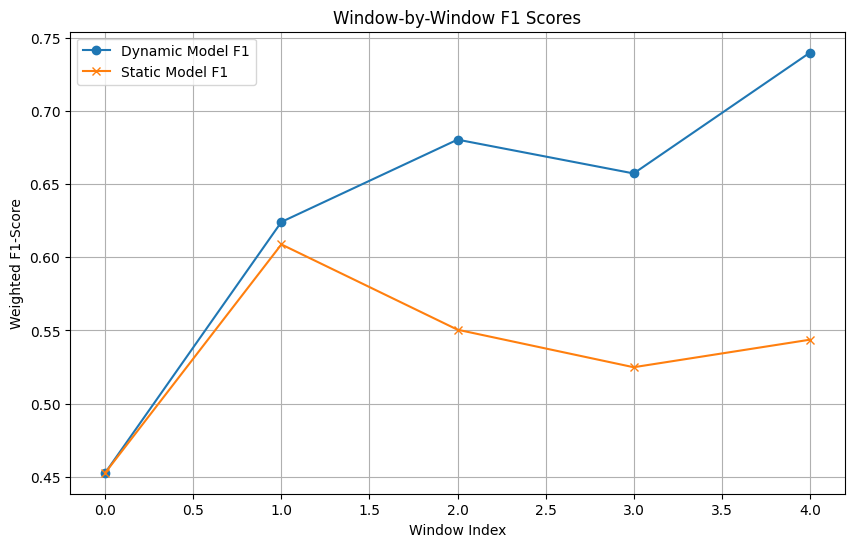

In [ ]:
import matplotlib.pyplot as plt

# Plotting F1 scores per window
plt.figure(figsize=(10, 6))
plt.plot(window_indices, dynamic_model_f1, label='Dynamic Model F1', marker='o')
plt.plot(window_indices, static_model_f1, label='Static Model F1', marker='x')
plt.xlabel('Window Index')
plt.ylabel('Weighted F1-Score')
plt.title('Window-by-Window F1 Scores')
plt.legend()
plt.grid(True)
plt.show()
